In [ ]:
# 1.3. 데이터 시각화 - 주요 차트 내용 중 박스 플롯 hue 구현 예제 코드

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Seaborn 내장 데이터셋 로드
tips = sns.load_dataset('tips')

# 데이터 준비
days = tips['day'].unique()
smokers = tips['smoker'].unique()

plt.figure(figsize=(8, 5))

# 각 day와 smoker 그룹별로 박스플롯 그리기
positions = []
data_to_plot = []
pos = 1

for day in sorted(days):  # day 순서대로
    for smoker in sorted(smokers):  # smoker = No, Yes
        group = tips[(tips['day'] == day) & (tips['smoker'] == smoker)]['total_bill']
        data_to_plot.append(group)
        positions.append(pos)
        pos += 1
    pos += 1  # day 사이 간격

# 박스플롯 그리기
bp = plt.boxplot(data_to_plot, positions=positions, widths=0.6, patch_artist=True)

# 색상 채우기 (smoker 구분)
colors = ['lightblue', 'lightcoral'] * len(days)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# x축 레이블: day 가운데 배치
xticks = []
xlabels = []
for i, day in enumerate(sorted(days)):
    xticks.append((i* (len(smokers)+1)) + 1.5)  # day 그룹의 중앙
    xlabels.append(day)

plt.xticks(xticks, xlabels)
plt.xlabel("day")
plt.ylabel("total_bill")
plt.title('Total Bill Distribution by Day and Smoker')

# 범례 추가
from matplotlib.patches import Patch
legend_handles = [Patch(color='lightblue', label='No'),
                  Patch(color='lightcoral', label='Yes')]
plt.legend(handles=legend_handles, title="smoker")

plt.show()

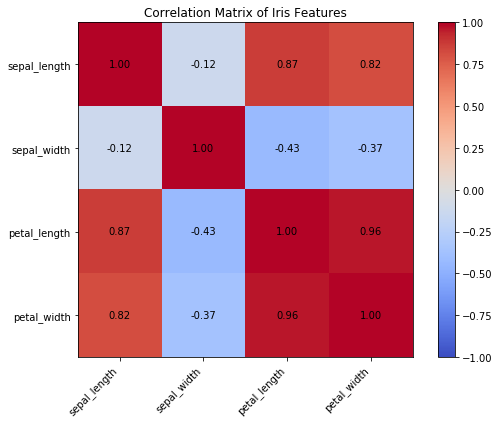

In [49]:
# 1.3. 데이터 시각화 - 주요 차트 내용 중 heatmap 예제 코드

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Seaborn 내장 데이터셋 로드
iris = sns.load_dataset('iris')

# 수치형 변수 간 상관계수 계산
corr = iris.corr()

# 히트맵 그리기
fig, ax = plt.subplots(figsize=(8, 6))

# imshow로 색상 맵 시각화
cax = ax.imshow(corr.values, cmap='coolwarm', vmin=-1, vmax=1)

# 컬럼 이름으로 x, y축 라벨 설정
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha='right')
ax.set_yticklabels(corr.columns)

# 각 셀에 상관계수 값 표시
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        ax.text(j, i, f"{corr.values[i, j]:.2f}", ha='center', va='center', color='black')

# 컬러바 추가
fig.colorbar(cax)

plt.title('Correlation Matrix of Iris Features')
plt.tight_layout()
plt.show()


In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# 1. 데이터 준비 및 전처리
housing = fetch_california_housing()
X = housing.data
y = housing.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVR은 스케일링이 매우 중요
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. SVR 모델 학습 (RBF 커널)
# 주요 하이퍼파라미터
# kernel: 커널 종류 ('linear', 'poly', 'rbf', 'sigmoid')
# C: 규제 파라미터
# epsilon: 오차 허용 범위
# gamma: 커널 계수
svr_rbf = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_rbf.fit(X_train_scaled, y_train)
svr_pred = svr_rbf.predict(X_test_scaled)
print(f"SVR (RBF Kernel) MSE: {mean_squared_error(y_test, svr_pred):.3f}")

# 3. GridSearchCV를 이용한 최적 하이퍼파라미터 탐색
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1],
    'epsilon': [0.1, 0.5]
}

grid_svr = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=3, # cv=5는 시간이 오래 걸릴 수 있음
                        scoring='neg_mean_squared_error', n_jobs=-1)
grid_svr.fit(X_train_scaled, y_train)

print("\nGridSearchCV 최적 파라미터 (SVR):", grid_svr.best_params_)
print(f"최적 파라미터 적용 시 MSE: {-grid_svr.best_score_:.3f} (교차검증 평균)")

# 최적 모델로 예측
best_svr = grid_svr.best_estimator_
best_pred = best_svr.predict(X_test_scaled)
print(f"Best SVR MSE: {mean_squared_error(y_test, best_pred):.3f}")

SVR (RBF Kernel) MSE: 0.357

GridSearchCV 최적 파라미터 (SVR): {'C': 10, 'epsilon': 0.1, 'gamma': 'scale'}
최적 파라미터 적용 시 MSE: 0.325 (교차검증 평균)
Best SVR MSE: 0.324


In [14]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 1. 데이터 준비
housing = fetch_california_housing()
X, y = housing.data, housing.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. 그래디언트 부스팅 (Scikit-learn)
from sklearn.ensemble import GradientBoostingRegressor
gb_reg = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_reg.fit(X_train, y_train)
gb_pred = gb_reg.predict(X_test)
print(f"Gradient Boosting MSE: {mean_squared_error(y_test, gb_pred):.3f}")

# 3. XGBoost
# !pip install xgboost
import xgboost as xgb
xgb_reg = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
print(f"XGBoost MSE: {mean_squared_error(y_test, xgb_pred):.3f}")

# 4. LightGBM
# !pip install lightgbm
import lightgbm as lgb
lgbm_reg = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, n_jobs=-1)
lgbm_reg.fit(X_train, y_train)
lgbm_pred = lgbm_reg.predict(X_test)
print(f"LightGBM MSE: {mean_squared_error(y_test, lgbm_pred):.3f}")

# 5. 조기 종료(Early Stopping) 기능 활용 (LightGBM 예시)
# 검증 세트 준비
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

lgbm_reg_early = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42)
# early_stopping_rounds: 검증 성능이 향상되지 않아도 기다릴 반복 횟수
# eval_set: 성능 평가에 사용할 검증 세트
lgbm_reg_early.fit(X_train_sub, y_train_sub, 
                   eval_set=[(X_val, y_val)], 
                   eval_metric='rmse',
                   callbacks=[lgb.early_stopping(100, verbose=True)])

early_pred = lgbm_reg_early.predict(X_test)
print(f"\nLightGBM (Early Stopping) MSE: {mean_squared_error(y_test, early_pred):.3f}")

Gradient Boosting MSE: 0.294
[21:48:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost MSE: 0.295
LightGBM MSE: 0.289
[1]	valid_0's rmse: 1.13791	valid_0's l2: 1.29485
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.10336	valid_0's l2: 1.2174
[3]	valid_0's rmse: 1.06936	valid_0's l2: 1.14353
[4]	valid_0's rmse: 1.03784	valid_0's l2: 1.07711
[5]	valid_0's rmse: 1.00766	valid_0's l2: 1.01538
[6]	valid_0's rmse: 0.980535	valid_0's l2: 0.961448
[7]	valid_0's rmse: 0.953703	valid_0's l2: 0.90955
[8]	valid_0's rmse: 0.930176	valid_0's l2: 0.865227
[9]	valid_0's rmse: 0.90673	valid_0's l2: 0.822159
[10]	valid_0's rmse: 0.885854	valid_0's l2: 0.784737
[11]	valid_0's rmse: 0.865807	valid_0's l2: 0.749622
[12]	valid_0's rmse: 0.846359	valid_0's l2: 0.716324
[13]	valid_0's rmse: 0.828319	valid_0's l2: 0.686112
[14]	valid_0's rmse: 0.811233	valid_0'

[165]	valid_0's rmse: 0.494587	valid_0's l2: 0.244616
[166]	valid_0's rmse: 0.494223	valid_0's l2: 0.244256
[167]	valid_0's rmse: 0.494172	valid_0's l2: 0.244206
[168]	valid_0's rmse: 0.493837	valid_0's l2: 0.243875
[169]	valid_0's rmse: 0.493519	valid_0's l2: 0.243561
[170]	valid_0's rmse: 0.493222	valid_0's l2: 0.243268
[171]	valid_0's rmse: 0.493237	valid_0's l2: 0.243283
[172]	valid_0's rmse: 0.493026	valid_0's l2: 0.243074
[173]	valid_0's rmse: 0.492796	valid_0's l2: 0.242848
[174]	valid_0's rmse: 0.492762	valid_0's l2: 0.242814
[175]	valid_0's rmse: 0.492619	valid_0's l2: 0.242673
[176]	valid_0's rmse: 0.49241	valid_0's l2: 0.242468
[177]	valid_0's rmse: 0.492135	valid_0's l2: 0.242197
[178]	valid_0's rmse: 0.491911	valid_0's l2: 0.241976
[179]	valid_0's rmse: 0.49186	valid_0's l2: 0.241927
[180]	valid_0's rmse: 0.491723	valid_0's l2: 0.241792
[181]	valid_0's rmse: 0.49143	valid_0's l2: 0.241503
[182]	valid_0's rmse: 0.491323	valid_0's l2: 0.241398
[183]	valid_0's rmse: 0.49105	v

[322]	valid_0's rmse: 0.479931	valid_0's l2: 0.230334
[323]	valid_0's rmse: 0.47981	valid_0's l2: 0.230218
[324]	valid_0's rmse: 0.479907	valid_0's l2: 0.230311
[325]	valid_0's rmse: 0.479848	valid_0's l2: 0.230254
[326]	valid_0's rmse: 0.479801	valid_0's l2: 0.230209
[327]	valid_0's rmse: 0.479795	valid_0's l2: 0.230203
[328]	valid_0's rmse: 0.479721	valid_0's l2: 0.230132
[329]	valid_0's rmse: 0.479709	valid_0's l2: 0.230121
[330]	valid_0's rmse: 0.479645	valid_0's l2: 0.230059
[331]	valid_0's rmse: 0.479471	valid_0's l2: 0.229892
[332]	valid_0's rmse: 0.47934	valid_0's l2: 0.229767
[333]	valid_0's rmse: 0.479301	valid_0's l2: 0.229729
[334]	valid_0's rmse: 0.47926	valid_0's l2: 0.22969
[335]	valid_0's rmse: 0.479261	valid_0's l2: 0.229691
[336]	valid_0's rmse: 0.479125	valid_0's l2: 0.229561
[337]	valid_0's rmse: 0.479118	valid_0's l2: 0.229554
[338]	valid_0's rmse: 0.479041	valid_0's l2: 0.229481
[339]	valid_0's rmse: 0.479096	valid_0's l2: 0.229533
[340]	valid_0's rmse: 0.479087	v

[489]	valid_0's rmse: 0.475146	valid_0's l2: 0.225763
[490]	valid_0's rmse: 0.475089	valid_0's l2: 0.22571
[491]	valid_0's rmse: 0.475043	valid_0's l2: 0.225666
[492]	valid_0's rmse: 0.475045	valid_0's l2: 0.225668
[493]	valid_0's rmse: 0.47499	valid_0's l2: 0.225616
[494]	valid_0's rmse: 0.474964	valid_0's l2: 0.225591
[495]	valid_0's rmse: 0.474963	valid_0's l2: 0.22559
[496]	valid_0's rmse: 0.474901	valid_0's l2: 0.225531
[497]	valid_0's rmse: 0.4749	valid_0's l2: 0.22553
[498]	valid_0's rmse: 0.474891	valid_0's l2: 0.225521
[499]	valid_0's rmse: 0.474948	valid_0's l2: 0.225575
[500]	valid_0's rmse: 0.474913	valid_0's l2: 0.225543
[501]	valid_0's rmse: 0.474863	valid_0's l2: 0.225495
[502]	valid_0's rmse: 0.474844	valid_0's l2: 0.225477
[503]	valid_0's rmse: 0.474852	valid_0's l2: 0.225484
[504]	valid_0's rmse: 0.474851	valid_0's l2: 0.225484
[505]	valid_0's rmse: 0.474814	valid_0's l2: 0.225448
[506]	valid_0's rmse: 0.47481	valid_0's l2: 0.225444
[507]	valid_0's rmse: 0.474716	vali

[668]	valid_0's rmse: 0.471455	valid_0's l2: 0.22227
[669]	valid_0's rmse: 0.471461	valid_0's l2: 0.222275
[670]	valid_0's rmse: 0.471451	valid_0's l2: 0.222266
[671]	valid_0's rmse: 0.471468	valid_0's l2: 0.222282
[672]	valid_0's rmse: 0.471371	valid_0's l2: 0.22219
[673]	valid_0's rmse: 0.471344	valid_0's l2: 0.222165
[674]	valid_0's rmse: 0.471332	valid_0's l2: 0.222154
[675]	valid_0's rmse: 0.471269	valid_0's l2: 0.222095
[676]	valid_0's rmse: 0.47127	valid_0's l2: 0.222096
[677]	valid_0's rmse: 0.471227	valid_0's l2: 0.222055
[678]	valid_0's rmse: 0.47127	valid_0's l2: 0.222096
[679]	valid_0's rmse: 0.471242	valid_0's l2: 0.222069
[680]	valid_0's rmse: 0.471145	valid_0's l2: 0.221978
[681]	valid_0's rmse: 0.471051	valid_0's l2: 0.221889
[682]	valid_0's rmse: 0.471033	valid_0's l2: 0.221872
[683]	valid_0's rmse: 0.471014	valid_0's l2: 0.221854
[684]	valid_0's rmse: 0.471059	valid_0's l2: 0.221897
[685]	valid_0's rmse: 0.470915	valid_0's l2: 0.221761
[686]	valid_0's rmse: 0.470874	v

[842]	valid_0's rmse: 0.469061	valid_0's l2: 0.220018
[843]	valid_0's rmse: 0.469063	valid_0's l2: 0.220021
[844]	valid_0's rmse: 0.469089	valid_0's l2: 0.220045
[845]	valid_0's rmse: 0.469088	valid_0's l2: 0.220044
[846]	valid_0's rmse: 0.469079	valid_0's l2: 0.220035
[847]	valid_0's rmse: 0.469052	valid_0's l2: 0.220009
[848]	valid_0's rmse: 0.469033	valid_0's l2: 0.219992
[849]	valid_0's rmse: 0.469029	valid_0's l2: 0.219989
[850]	valid_0's rmse: 0.469041	valid_0's l2: 0.219999
[851]	valid_0's rmse: 0.469052	valid_0's l2: 0.22001
[852]	valid_0's rmse: 0.469077	valid_0's l2: 0.220034
[853]	valid_0's rmse: 0.468983	valid_0's l2: 0.219945
[854]	valid_0's rmse: 0.468949	valid_0's l2: 0.219913
[855]	valid_0's rmse: 0.468922	valid_0's l2: 0.219888
[856]	valid_0's rmse: 0.468988	valid_0's l2: 0.219949
[857]	valid_0's rmse: 0.469075	valid_0's l2: 0.220032
[858]	valid_0's rmse: 0.469049	valid_0's l2: 0.220007
[859]	valid_0's rmse: 0.469025	valid_0's l2: 0.219985
[860]	valid_0's rmse: 0.46899


LightGBM (Early Stopping) MSE: 0.191
